# MatrixMatch

In [1]:
import time
begin_start_time = time.time()
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
print(time_str)

2026-01-08 10-52-08


In [2]:
import torch, pandas as pd, os
import matplotlib.pyplot as plt
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
from PPO.ppo_agent_eval import *
from DQN.h2h_to_excel import append_h2h_to_excel
from C4.eval_oppo_dict import *
from C4.CNet192 import CNet192, save_cnet192, load_cnet192
from C4.utilities import make_hof_metascores

In [4]:
ENSEMBLE = [

    #EXP_3
    "PPO_Models/MIX_55.pt",    # EXPERT_3 -> MIX_5 -> MIX_6b -> MIX_7b -> MIX_11 -> MIX_33a -> MIX_43 -> MIX_55
    "PPO_Models/MIX_54.pt",    # EXPERT_3 -> MIX_5 -> MIX_6b -> MIX_7b -> MIX_11 -> MIX_33b ->  MIX_35 -> MIX_54
    "PPO_Models/MIX_44.pt",    # EXPERT_3 -> MIX_5 -> MIX_6b -> MIX_7a -> MIX_17 -> MIX_19 -> MIX_22a -> MIX_41b -> MIX_44
    "PPO_Models/MIX_34.pt",    # EXPERT_3 -> MIX_5 -> MIX_6a -> MIX_8 -> MIX_12b --> MIX_23 -> MIX_29 -> MIX_31a -> MIX_34

    #EXP_4
    #"PPO_Models/MIX_56.pt",    # EXPERT_4 -> MIX_13b -> MIX_18a -> MIX_21a -> MIX_30 -> MIX_40 -> MIX_47b -> MIX_51 -> MIX_56
    "PPO_Models/MIX_57a.pt",    # EXPERT_4 -> MIX_13b -> MIX_18a -> MIX_21a -> MIX_30 -> MIX_40 -> MIX_47b -> MIX_51 -> MIX_56 -> MIX_57a
    #"PPO_Models/MIX_57b.pt",    # EXPERT_4 -> MIX_13b -> MIX_18a -> MIX_21a -> MIX_30 -> MIX_40 -> MIX_47b -> MIX_51 -> MIX_56 -> MIX_57b
    
    #EXP_5
    "PPO_Models/MIX_42b.pt",    # EXPERT_5 -> MIX_42b
    #"PPO_Models/MIX_45a.pt",    # EXPERT_5 -> MIX_42a -> MIX_45a
    "PPO_Models/MIX_45b.pt",    # EXPERT_5 -> MIX_42a -> MIX_45b
    "PPO_Models/MIX_58.pt",    # EXPERT_5 -> MIX_42a -> MIX_45a -> MIX_58


    #plateaued - keep
    #"PPO_Models/MIX_39.pt",   # EXPERT_4 -> MIX_13b -> MIX_18a -> MIX_21b -> MIX_36a -> MIX_38 -> MIX_39 # plateau
    #"PPO_Models/MIX_50.pt",    # EXPERT_4 -> MIX_13b -> MIX_18a -> MIX_21a -> MIX_30 -> MIX_40 -> MIX_46 -> MIX_48 -> MIX_49b -> MIX__50 # plateau
    #"PPO_Models/MIX_53.pt",    # EXPERT_4 -> MIX_13b -> MIX_18a -> MIX_21a -> MIX_30 -> MIX_40 -> MIX_46 -> MIX_48 -> MIX_49a -> MIX_52 -> MIX_53 plateau

]

In [5]:
policies = {}

for path in ENSEMBLE:
    name = path.split("/")[-1].split(".")[0]
    m, _ = load_cnet192(path, device=DEVICE, strict=True)
    m.eval()
    policies[name] = m
    

In [6]:
mat, details = round_robin_matrix(
    policies,
    n_games=500,
    device=DEVICE,
    opening_noise_k=OPENING_NOISE_K,
    seed=123,
    progress=True,
    paired_openings=True,
    opening_bias="center",
    return_details=True,
)
meta = metascores_from_matrix(mat)

Round-robin:   0%|          | 0/28 [00:00<?, ?it/s]

In [7]:
display(mat)

,MIX_55,MIX_54,MIX_44,MIX_34,MIX_57a,MIX_42b,MIX_45b,MIX_58
MIX_55,0.500,0.504,0.490,0.492,0.039,0.460,0.484,0.910
MIX_54,0.496,0.500,0.077,0.497,0.955,0.710,0.722,0.271
MIX_44,0.510,0.923,0.500,0.025,0.929,0.703,0.491,0.904
MIX_34,0.508,0.503,0.975,0.500,0.262,0.500,0.477,0.937
MIX_57a,0.961,0.045,0.071,0.738,0.500,0.047,0.034,0.504
MIX_42b,0.540,0.290,0.297,0.500,0.953,0.500,0.510,0.061
MIX_45b,0.516,0.278,0.509,0.523,0.966,0.490,0.500,0.483
MIX_58,0.090,0.729,0.096,0.063,0.496,0.939,0.517,0.500


In [8]:
display(meta)

MIX_55     0.482714
MIX_54     0.532571
MIX_44     0.640714
MIX_34     0.594571
MIX_57a    0.342857
MIX_42b    0.450143
MIX_45b    0.537857
MIX_58     0.418571
Name: meta_score, dtype: float64

In [9]:
print(make_hof_metascores(meta, ENSEMBLE, decimals=6))

HOF_METASCORES = {
    "PPO_Models/MIX_44.pt": 0.640714,
    "PPO_Models/MIX_34.pt": 0.594571,
    "PPO_Models/MIX_45b.pt": 0.537857,
    "PPO_Models/MIX_54.pt": 0.532571,
    "PPO_Models/MIX_55.pt": 0.482714,
    "PPO_Models/MIX_42b.pt": 0.450143,
    "PPO_Models/MIX_58.pt": 0.418571,
    "PPO_Models/MIX_57a.pt": 0.342857,
}


In [10]:
OUT_DIR = "Logs/PPO_matrix/"
matches_df, ranking = export_round_robin_bundle_to_excel(mat, details, out_dir=OUT_DIR)

Saved matrix / matches / ranking to Logs/PPO_matrix/


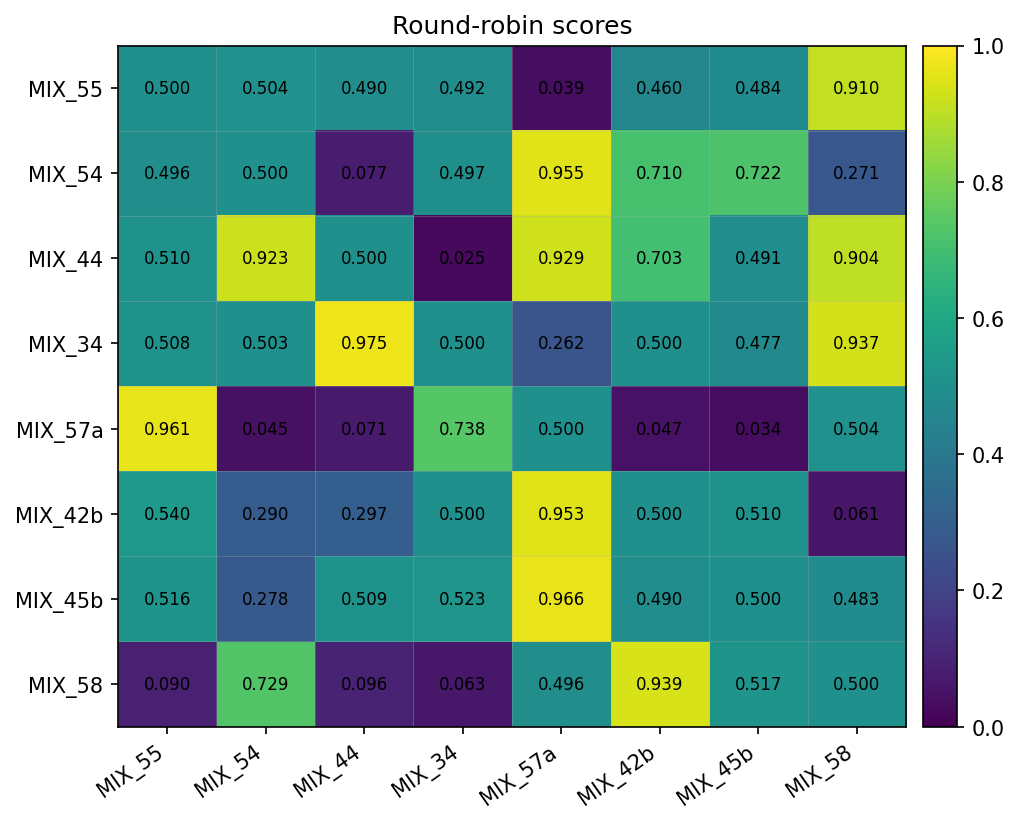

In [11]:
fig = plot_rr_heatmap(mat, title="Round-robin scores")
plt.show()

In [12]:
end_time = time.time()
total_elapsed = (end_time - begin_start_time) / 60
print(f"Evaluation completed in {total_elapsed:.1f} minutes")

Evaluation completed in 3.8 minutes
